### Dependencies


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Import Data in Dataframe

In [2]:
df= pd.read_csv('data.csv')
df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp


### Data Exploration

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
len(df)

### Preprocessing

#### Encoders

In [3]:
le = preprocessing.LabelEncoder()
df['type_code'] = le.fit_transform(df['dx_type'])
df['sex_code'] = le.fit_transform(df['sex'])
df['localization_code'] = le.fit_transform(df['localization'])
df['dx_code'] = le.fit_transform(df['dx'])
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,type_code,sex_code,localization_code,dx_code
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,3,1,11,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,3,1,11,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,3,1,11,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,3,1,11,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,3,1,4,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,3,1,4,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,3,1,5,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,3,1,5,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,3,0,2,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,3,0,2,2


#### Nomenclature

In [4]:
Type_Nomenclature = df[["dx_type" , "type_code"]]
df= df.drop(columns='dx_type')
Type_Nomenclature = Type_Nomenclature.drop_duplicates()
Type_Nomenclature.head(5)

,dx_type,type_code
0,histo,3
64,consensus,1
767,confocal,0
1210,follow_up,2


In [5]:
Sex_Nomenclature = df[["sex" , "sex_code"]]
df= df.drop(columns='sex')
Sex_Nomenclature = Sex_Nomenclature.drop_duplicates()
Sex_Nomenclature.head(5)

,sex,sex_code
0,male,1
8,female,0
968,unknown,2


In [6]:
Localization_Nomenclature = df[["localization" , "localization_code"]]
# df= df.drop(columns='localization')
Localization_Nomenclature = Localization_Nomenclature.drop_duplicates()
Localization_Nomenclature.head(5)

,localization,localization_code
0,scalp,11
4,ear,4
6,face,5
8,back,2
10,trunk,12


In [7]:
DX_Nomenclature = df[["dx" , "dx_code"]]
df= df.drop(columns='dx')
DX_Nomenclature = DX_Nomenclature.drop_duplicates()
DX_Nomenclature.head(5)
# DX = Tumor Type     
#     'nv': 'Melanocytic nevi',
#     'mel': 'dermatofibroma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'

,dx,dx_code
0,bkl,2
64,nv,5
1095,df,3
1211,mel,4
2320,vasc,6


In [8]:
df_ready = df.drop(columns=['image_id'])
df_ready.head(2)

,lesion_id,age,localization,type_code,sex_code,localization_code,dx_code
0,HAM_0000118,80.0,scalp,3,1,11,2
1,HAM_0000118,80.0,scalp,3,1,11,2


### Visulaization and Analysis

In [38]:
females = df_ready["sex_code"] == 0 
df_females = df_ready[females]
# df_females.tail(5)

In [27]:
B= df_females.localization.value_counts().index.tolist()
A = df_females.localization.value_counts().tolist()

In [28]:
females_plot_df = pd.DataFrame({'localization': [], 'count': []})

females_plot_df['localization']  = B
females_plot_df['count'] = A

# females_plot_df.head(10)

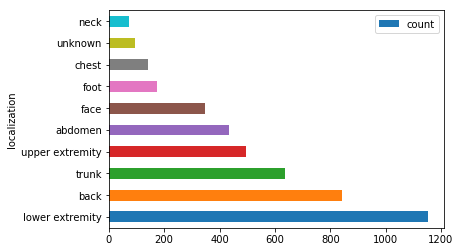

In [29]:
ax = females_plot_df[:10].plot.barh(x='localization', y='count', rot=0, )

In [30]:
males = df_ready["sex_code"] == 1
df_males = df_ready[males]
# df_males.tail(5)

In [31]:
B= df_males.localization.value_counts().index.tolist()
A = df_males.localization.value_counts().tolist()

In [32]:
males_plot_df = pd.DataFrame({'localization': [], 'count': []})

males_plot_df['localization']  = B
males_plot_df['count'] = A

# males_plot_df.head(10)

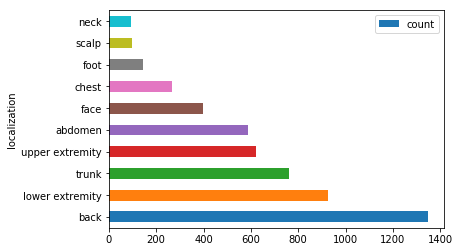

In [33]:
ax = males_plot_df[:10].plot.barh(x='localization', y='count', rot=0, )

### Machine Learning: Target = Gender

#### Function to display confusion matrix

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Training and Test Sets

In [10]:
df_ready.isnull().sum()
# df_ready.dropna()
# df_ready.head(2)

lesion_id             0
age                  57
localization          0
type_code             0
sex_code              0
localization_code     0
dx_code               0
dtype: int64

In [11]:
df_ready.isna().sum()
df_ML = df_ready.dropna()

In [12]:
df_ML.isna().sum()

lesion_id            0
age                  0
localization         0
type_code            0
sex_code             0
localization_code    0
dx_code              0
dtype: int64

In [13]:
X = df_ML[["type_code", "age", "localization_code", "dx_code"]]
Y = df_ML[["sex_code"]]

In [14]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, Y, test_size=0.3, random_state=3)

### Decision Tree (  Accu = 0.61 )

#### Train model

In [31]:
GenderTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
GenderTree 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
GenderTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Predict

In [33]:
predTree = GenderTree.predict(X_testset)

In [34]:
print (predTree [0:5])
print (y_testset [0:5])

[0 0 0 0 1]
      sex_code
5552         1
4644         0
5022         0
8448         0
2729         0


#### Evaluate

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6107764390896921


### Logistic Regression (Accu = 0.59)

#### Train Model

In [15]:
LogisticRegression = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

In [16]:
LogisticRegression.fit(X_trainset, y_trainset)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

#### Predict

In [17]:
predLR  = LogisticRegression.predict(X_testset)

In [18]:
print (predLR [0:5])
print (y_testset [0:5])


[1 0 1 0 1]
      sex_code
5552         1
4644         0
5022         0
8448         0
2729         0


#### Evaluate

In [19]:
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_testset, predLR))

Logistic Regression's Accuracy:  0.5903614457831325


In [20]:
print(confusion_matrix(y_testset, predLR, labels=[1,0]))

[[1234  362]
 [ 855  530]]
